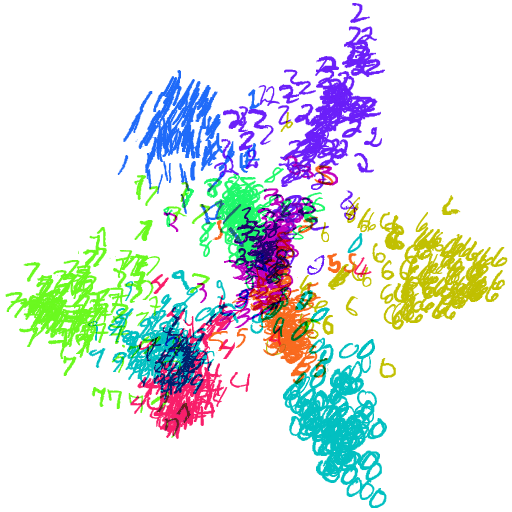

0.866


ValueError: c of shape (6000,) not acceptable as a color sequence for x with size 60000, y with size 60000

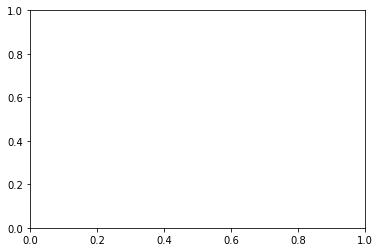

In [14]:
# -*- coding: utf-8 -*-
import os
from collections import defaultdict

import keras
import numpy as np
import tensorflow as tf
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.datasets import mnist
from keras.layers import Dense, Input, Flatten, Dropout, MaxPooling2D, Conv2D
from matplotlib import pyplot as plt
from scipy.spatial import distance
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.contrib.tensorboard.plugins import projector
from keras import backend as K, Sequential
import random
from IPython.display import clear_output
from utils.build_rainbow import build_rainbow
from utils.plot_images import plot_images
from utils.show_array import show_array


def triplet_loss_2(y_true, y_pred, alpha=0.3):
    anchor, positive, negative = y_pred[:1], y_pred[2:3], y_pred[3:]

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=1)
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))

    return loss


def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.mean(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.mean(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, 1 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)


def simple_net(input_shape, output_shape):
    # input = Input(input_shape)
    # x = Flatten()(input)
    # out = Dense(output_shape, activation='relu')(x)

    # model = Model(input, out)
    # model.summary()

    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_shape, activation='linear'))

    return model


def build_model(input_shape, output_shape):
    embedding_model = Sequential()

    embedding_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    embedding_model.add(Conv2D(64, (3, 3), activation='relu'))
    embedding_model.add(MaxPooling2D(pool_size=(2, 2)))
    embedding_model.add(Dropout(0.25))
    embedding_model.add(Flatten())
    embedding_model.add(Dense(128, activation='relu'))
    embedding_model.add(Dropout(0.5))
    embedding_model.add(Dense(output_shape, activation='linear'))

    anchor_input = Input(input_shape, name='anchor_input')
    positive_input = Input(input_shape, name='positive_input')
    negative_input = Input(input_shape, name='negative_input')

    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    inputs = [anchor_input, positive_input, negative_input]
    outputs = [anchor_embedding, positive_embedding, negative_embedding]

    triplet_model = Model(inputs=inputs, outputs=outputs)
    triplet_model.add_loss(K.mean(triplet_loss(outputs)))
    triplet_model.compile(optimizer='adam', loss=None)

    return embedding_model, triplet_model


def get_resnet(input_shape, output_shape):
    input = Input(input_shape)

    model = ResNet50(input_tensor=input, classes=output_shape, weights=None, include_top=False)

    return model


def get_vgg(input_shape, output_shape):
    input = Input(input_shape)

    model = VGG16(input_shape=(28, 28, 3), weights=None, include_top=False)

    return model


def generate_hard_triplets(dist, data, y, count=100):
    i = 0
    dlist = []
    clist = []

    # x_train_2d = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
    # dist_pos = np.linalg.norm(x_train_2d - x_train_2d[:, None], axis=-1)
    dist_pos = distance.cdist(dist, dist, metric='euclidean')
    np.fill_diagonal(dist_pos, np.nan)

    dist_neg = np.array(dist_pos, copy=True)

    while True:
        anchor, cls = data[[i]], y[[i]]

        # prendre i qui maximise la distance en pos et anchor
        pos_mask = np.array(y == cls)
        dist_pos[i][~pos_mask] = np.nan
        max_idx = np.nanargmax(dist_pos[i])

        pos = data[[max_idx]]

        # prendre i qui minimise la distance en pos et anchor
        neg_mask = np.array(y != cls)
        dist_neg[i][~neg_mask] = np.nan
        min_idx = np.nanargmin(dist_neg[i])

        neg = data[[min_idx]]

        dlist.append([anchor, pos, neg])
        clist.append(cls)

        i += 1
        if i == count:
            return dlist, clist


def generate_triplets(x_train, y_train, count=100):
    i = 0
    dlist = []
    clist = []

    while True:
        i += 1
        idx = np.random.randint(0, y_train.shape[0])
        anchor, cls = x_train[[idx]], y_train[[idx]]
        pos = x_train[y_train == cls][[i % (y_train == cls).sum()]]
        neg = x_train[y_train != cls][[i % (y_train == cls).sum()]]
        dlist.append([anchor, pos, neg])
        clist.append(cls)
        if i == count:
            return dlist, clist


def get_triples_indices(grouped, n):
    num_classes = len(grouped)
    positive_labels = np.random.randint(0, num_classes, size=n)
    negative_labels = (np.random.randint(1, num_classes, size=n) + positive_labels) % num_classes
    triples_indices = []
    for positive_label, negative_label in zip(positive_labels, negative_labels):
        negative = np.random.choice(grouped[negative_label])
        positive_group = grouped[positive_label]
        m = len(positive_group)
        anchor_j = np.random.randint(0, m)
        anchor = positive_group[anchor_j]
        positive_j = (np.random.randint(1, m) + anchor_j) % m
        positive = positive_group[positive_j]
        triples_indices.append([anchor, positive, negative])
    return np.asarray(triples_indices)


def get_hard_triples_indices(x, grouped, n, embedding_model):
    num_classes = len(grouped)
    positive_labels = np.random.randint(0, num_classes, size=n)
    negative_labels = (np.random.randint(1, num_classes, size=n) + positive_labels) % num_classes
    triples_indices = []
    embeddings = []

    for i in range(num_classes):
        embeddings.append(embedding_model.predict(x[grouped[i]]))

    for positive_label, negative_label in zip(positive_labels, negative_labels):

        negative = np.random.choice(grouped[negative_label])

        positive_group = grouped[positive_label]
        m = len(positive_group)

        positive_j = np.random.randint(0, m)
        positive = positive_group[positive_j]

        # Negative and positive are randomly chosen, anchor must be far from positive and close to negative
        # anchor_j = (np.random.randint(1, m) + positive_j) % m

        # positive_group_emb = embedding_model.predict(x[positive_group])
        positive_emb = np.expand_dims(embeddings[positive_label][positive_j], axis=0)
        negative_emb = embedding_model.predict(np.expand_dims(x[negative], axis=0))
        
        random.shuffle(embeddings[positive_label])
        emb_min = embeddings[positive_label][0:32]

        positive_distance = distance.cdist(positive_emb, emb_min, metric='sqeuclidean')
        negative_distance = distance.cdist(negative_emb, emb_min, metric='sqeuclidean')

        # anchor_j = (np.random.randint(1, m) + positive_j) % m
        anchor_j = np.argmax(positive_distance - negative_distance)
        anchor = positive_group[anchor_j]

        triples_indices.append([anchor, positive, negative])

    return np.asarray(triples_indices)


def get_triples_data(x, grouped, n):
    indices = get_triples_indices(grouped, n)
    return x[indices[:, 0]], x[indices[:, 1]], x[indices[:, 2]]


def get_hard_triples_data(x, grouped, n, embedding_model):
    indices = get_hard_triples_indices(x, grouped, n, embedding_model)
    return x[indices[:, 0]], x[indices[:, 1]], x[indices[:, 2]]


def triplet_generator(x, y, batch_size):
    grouped = defaultdict(list)
    for i, label in enumerate(y):
        grouped[label].append(i)

    while True:
        x_anchor, x_positive, x_negative = get_triples_data(x, grouped, batch_size)
        yield ({'anchor_input': x_anchor,
                'positive_input': x_positive,
                'negative_input': x_negative},
               None)


def hard_triplet_generator(x, y, batch_size, embedding_model):
    grouped = defaultdict(list)
    for i, label in enumerate(y):
        grouped[label].append(i)

    while True:
        x_anchor, x_positive, x_negative = get_hard_triples_data(x, grouped, batch_size, embedding_model)
        yield ({'anchor_input': x_anchor,
                'positive_input': x_positive,
                'negative_input': x_negative},
               None)


def tensorboard():
    # Create randomly initialized embedding weights which will be trained.
    N = 10000  # Number of items (vocab size).
    D = 200  # Dimensionality of the embedding.

    sess = tf.Session()

    embedding_var = tf.Variable(tf.random_normal([N, D]), name='word_embedding')

    # Format: tensorflow/contrib/tensorboard/plugins/projector/projector_config.proto
    config = projector.ProjectorConfig()

    # You can add multiple embeddings. Here we add only one.
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_var.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')

    # Use the same LOG_DIR where you stored your checkpoint.
    summary_writer = tf.summary.FileWriter(LOG_DIR)

    saver = tf.train.Saver()
    saver.save(sess, '../logs/model.ckpt', 0)

    # The next line writes a projector_config.pbtxt in the LOG_DIR. TensorBoard will
    # read this file during startup.
    projector.visualize_embeddings(summary_writer, config)


class Plotter(keras.callbacks.Callback):
    def __init__(self, embedding_model, x, images, plot_size):
        self.embedding_model = embedding_model
        self.x = x
        self.images = images
        self.plot_size = plot_size

    def on_epoch_end(self, epoch, logs={}):
        clear_output(wait=True)
        xy = self.embedding_model.predict(self.x[:self.plot_size])
        show_array(255 - plot_images(self.images[:self.plot_size].squeeze(), xy))


if __name__ == '__main__':
    path = '/Users/Philippe/Programmation/research-purposes/data/a0001-jmac_DSC1459.dng'

    train_length = 6000
    test_length = 1000
    in_dims = (28, 28, 1)
    out_dims = 2
    LOG_DIR = '../logs'
    batch_size = 256
    steps_per_epoch = 1
    epochs = 100
    plot_size = 1024

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
    x_test = x_test.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)

    colors = build_rainbow(len(np.unique(y_train)))
    colored_x = np.asarray([colors[cur_y] * cur_x for cur_x, cur_y in zip(x_train, y_train)])

    embedding_model, triplet_model = build_model(in_dims, out_dims)
    plotter = Plotter(embedding_model, x_train, colored_x, plot_size)

    print(embedding_model.predict(np.expand_dims(x_train[0], axis=0)))

    triplet_model.fit_generator(hard_triplet_generator(x_train, y_train, batch_size, embedding_model),
                                steps_per_epoch=steps_per_epoch, epochs=epochs, callbacks=[plotter])
    # model.fit(x_triplet_train, cls, steps_per_epoch=64, epochs=1)
    #  model.save_weights('weights.h5')
    #  model.load_weights("/home/philippe/Code/research-purposes/weights.h5")

    x_train_emb = embedding_model.predict(x_train)
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(x_train_emb, np.ravel(y_train))
    score = neigh.score(x_train_emb, y_train)
    print(score)

    plt.scatter(x_train_emb[:, 0], x_train_emb[:, 1], c=y_train[:train_length])
    plt.show()
